In [3]:
import gc
import os
import sys
import threading

import numpy as np
import psutil
import torch
import random

from accelerate import Accelerator
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader

import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

from tqdm import tqdm

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from peft import PrefixTuningConfig, TaskType, get_peft_model


[nltk_data] Downloading package punkt to
[nltk_data]     /home/is/kaifan-l/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
model_name_or_path = "facebook/bart-large"
dataset_name = "cnn_dailymail"
text_column = 'article'
label_column = 'highlights'

In [5]:
cnn_dataset = load_dataset(dataset_name, "3.0.0")
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [6]:
def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    model_inputs = tokenizer(
        inputs,
        max_length=4096,
        truncation=True,
        padding=False
    ) # 这里暂时不padding
    targets = tokenizer(
        targets,
        max_length=2048,
        truncation=True,
        padding=True,
        return_tensors='pt',
    )
    targets = targets['input_ids']
    targets[targets == tokenizer.pad_token_id] = -100
    model_inputs['labels'] = targets
    
    return model_inputs

cnn_dataset = cnn_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=cnn_dataset["train"].column_names,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)
cnn_dataset

Running tokenizer on dataset: 100%|██████████| 13368/13368 [00:18<00:00, 741.70 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11490
    })
})

In [7]:
train_size = int(len(cnn_dataset["train"]) * 0.1)
eval_size = int(len(cnn_dataset["validation"]) * 0.1)
test_size = int(len(cnn_dataset["test"]) * 0.1)

train_dataset = cnn_dataset["train"].shuffle(seed=42).select(range(train_size))
eval_dataset = cnn_dataset["validation"].shuffle(seed=42).select(range(eval_size))
test_dataset = cnn_dataset["test"].shuffle(seed=42).select(range(test_size))

In [8]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 28711
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1336
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1149
 }))

In [36]:
import matplotlib.pyplot as plt
import datasets

def visualize_token_size_distribution(dataset, column_name='input_ids'):
    # 初始化用于存储不同 token 长度的样本数量的字典
    input_lengths = {}

    # 遍历数据集
    for example in dataset:
        # 排除标记为 -100 的值
        input_ids = [token_id for token_id in example[column_name] if token_id != -100]
        length = len(input_ids)

        # 统计样本数量
        if length in input_lengths:
            input_lengths[length] += 1
        else:
            input_lengths[length] = 1

    # 将字典按 token 长度排序
    sorted_lengths = sorted(input_lengths.items(), key=lambda x: x[0])

    # 提取 token 长度和样本数量
    token_lengths, sample_counts = zip(*sorted_lengths)

    # 可视化
    plt.figure(figsize=(12, 6))
    plt.bar(token_lengths, sample_counts)
    plt.xlabel('Token Length')
    plt.ylabel('Number of Samples')
    # 设置X轴范围
    if column_name == 'input_ids':
        plt.xlim(0, 4096)
    elif column_name == 'labels':
        plt.xlim(0, 256)
    plt.title('Distribution of Token Lengths in the Dataset')
    plt.show()


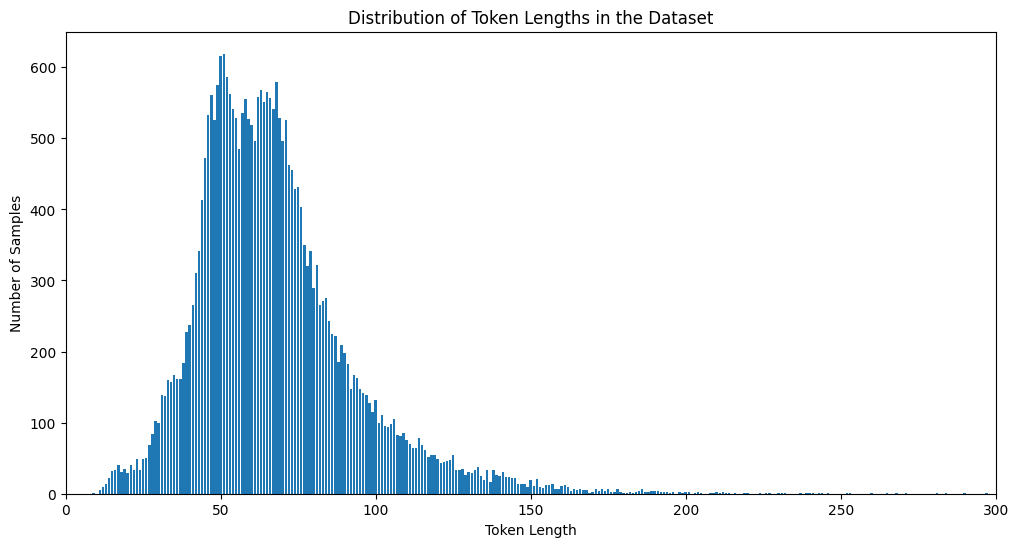

In [37]:
visualize_token_size_distribution(train_dataset, 'labels')

In [33]:
import matplotlib.pyplot as plt
import datasets

def visualize_token_size_distribution(dataset):
    # 初始化用于存储不同 token 长度的样本数量的字典
    input_lengths = {}
    label_lengths = {}

    # 遍历数据集
    for example in dataset:
        # 排除标记为 -100 的值
        input_ids = [token_id for token_id in example['input_ids'] if token_id != -100]
        label_ids = [label_id for label_id in example['labels'] if label_id != -100]
        input_length = len(input_ids)
        label_length = len(label_ids)

        # 统计样本数量
        if input_length in input_lengths:
            input_lengths[input_length] += 1
        else:
            input_lengths[input_length] = 1
        
        if label_length in label_lengths:
            label_lengths[label_length] += 1
        else:
            label_lengths[label_length] = 1

    # 将字典按 token 长度排序
    sorted_input_lengths = sorted(input_lengths.items(), key=lambda x: x[0])
    sorted_label_lengths = sorted(label_lengths.items(), key=lambda x: x[0])

    # 提取 token 长度和样本数量
    input_token_lengths, input_sample_counts = zip(*sorted_input_lengths)
    label_token_lengths, label_sample_counts = zip(*sorted_label_lengths)

    # 可视化
    plt.figure(figsize=(12, 6))
    plt.bar(input_token_lengths, input_sample_counts, label='Input Token Length')
    plt.bar(label_token_lengths, label_sample_counts, label='Label Token Length', alpha=0.7)
    plt.xlabel('Token Length')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Token Lengths in the Dataset')
    plt.legend()
    plt.show()

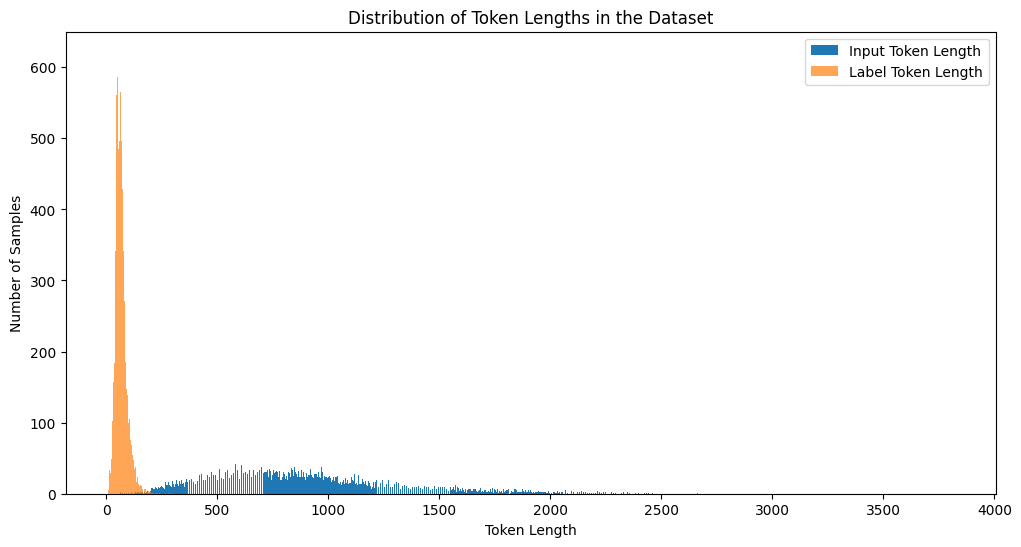

In [34]:
visualize_token_size_distribution(train_dataset)

In [9]:
import datasets

def count_input_ids(dataset_name, sequence_length=1024, split='train'):

    # 获取数据集分割
    data = dataset_name

    # 初始化计数器
    num_samples = len(data)
    num_above_length = 0
    num_below_length = 0

    # 遍历数据集
    for example in data:
        input_ids = example['input_ids']

        # 排除标记为 -100 的值
        input_ids = [token_id for token_id in input_ids if token_id != -100]

        # 计算 input_ids 长度
        input_length = len(input_ids)

        # 统计数量
        if input_length > sequence_length:
            num_above_length += 1
        else:
            num_below_length += 1

    # 计算百分比
    percent_above_length = (num_above_length / num_samples) * 100
    percent_below_length = (num_below_length / num_samples) * 100

    # 打印结果
    print(f"Samples with input_ids > {sequence_length}: {num_above_length} samples ({percent_above_length:.2f}%)")
    print(f"Samples with input_ids <= {sequence_length}: {num_below_length} samples ({percent_below_length:.2f}%)")

# 使用示例
count_input_ids(train_dataset, sequence_length=1024)

Samples with input_ids > 1024: 8675 samples (30.21%)
Samples with input_ids <= 1024: 20036 samples (69.79%)
